# Librerias

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import random
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fa-ii-2025-i-pronosticos-nn-rnn-cnn/sample_submission.csv
/kaggle/input/fa-ii-2025-i-pronosticos-nn-rnn-cnn/df_test.parquet
/kaggle/input/fa-ii-2025-i-pronosticos-nn-rnn-cnn/df_train.parquet


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" if torch.cuda.is_available() else "0"

In [5]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [6]:
reset_seed()

# Carga de datos

In [7]:
df = pd.read_parquet('/kaggle/input/fa-ii-2025-i-pronosticos-nn-rnn-cnn/df_train.parquet')
print(df.shape)
df.head(5)

(3680, 20)


,id,id_bar,anio,semana,ESTRATO,area_barrio,dengue,concentraciones,vivienda,equipesado,sumideros,maquina,lluvia_mean,lluvia_var,lluvia_max,lluvia_min,temperatura_mean,temperatura_var,temperatura_max,temperatura_min
0,4_2015_01,4,2015,1,3.0,0.560,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
1,5_2015_01,5,2015,1,3.0,0.842,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
2,3_2015_01,3,2015,1,1.0,0.781,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
3,8_2015_01,8,2015,1,2.0,0.394,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
4,9_2015_01,9,2015,1,2.0,0.292,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9


In [8]:
# Establecemos una variable que se llame fecha, donde solo te tienen en cuenta el año y el mes

df['fecha'] = df['anio'].astype(str) + df['semana'].astype(str).str.zfill(2)
df = df.sort_values(by=['fecha','id_bar'])

# Breve entendimiento

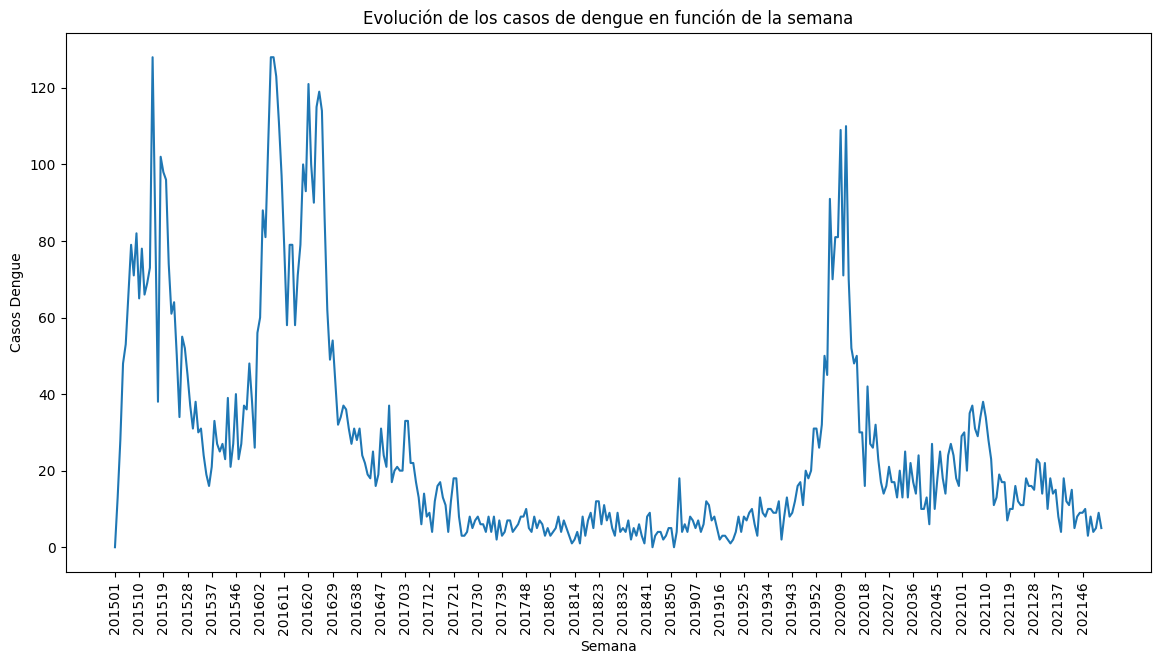

In [9]:

# Group by year and week, summing 'Casos_Dengue'
dengue_by_week = df.groupby(['fecha'])['dengue'].sum().reset_index()

# Rename columns for clarity
dengue_by_week.columns = ['fecha', 'dengue']

plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(dengue_by_week.fecha, dengue_by_week.dengue)
plt.xlabel('Semana')
plt.ylabel('Casos Dengue')
plt.title('Evolución de los casos de dengue en función de la semana')
plt.xticks(np.arange(0,368,9), rotation=90)
plt.show()

<Figure size 1400x700 with 0 Axes>

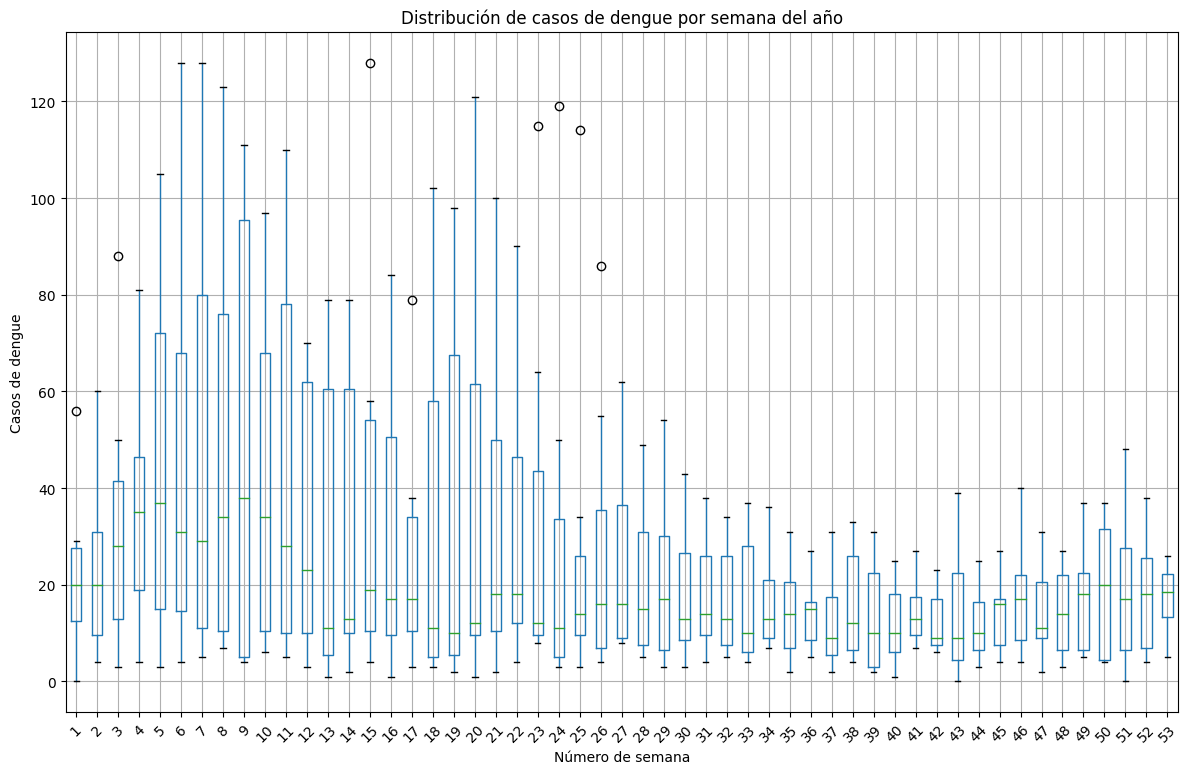

In [10]:
# Extract week number from the 'fecha' column
dengue_by_week['week'] = dengue_by_week['fecha'].str[4:].astype(int)

# Group by week number and create boxplots
plt.figure(figsize=(14, 7))
dengue_by_week.boxplot(column='dengue', by='week', figsize=(12, 8))
plt.title('Distribución de casos de dengue por semana del año')
plt.xlabel('Número de semana')
plt.ylabel('Casos de dengue')
plt.suptitle('') # Remove the default boxplot title
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


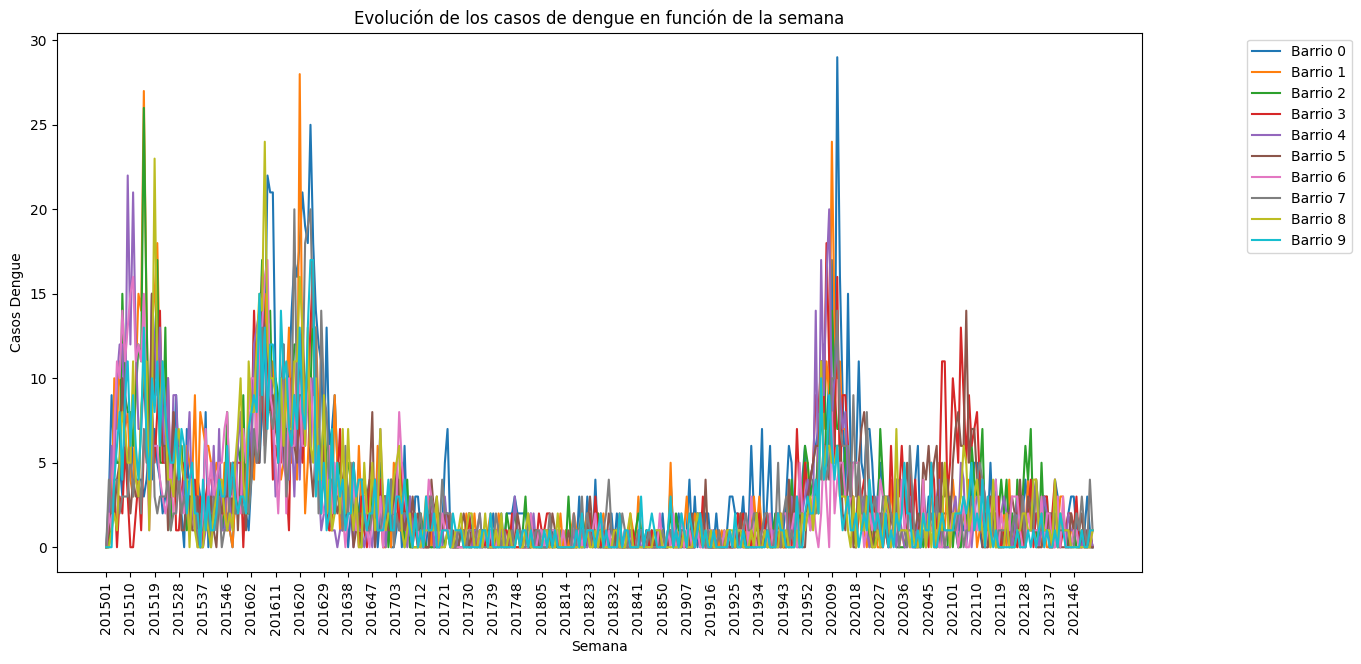

In [11]:
plt.figure(figsize=(14,7))
ax = plt.gca()  # Obtener el eje actual

# Graficar cada barrio en el mismo gráfico
for barrio_id in df['id_bar'].unique():
    plt.plot(df[df['id_bar'] == barrio_id]['fecha'], df[df['id_bar'] == barrio_id]['dengue'], label=f'Barrio {barrio_id}')

plt.xlabel('Semana')
plt.ylabel('Casos Dengue')
plt.title('Evolución de los casos de dengue en función de la semana')
plt.xticks(np.arange(0,368,9), rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Ajustar la leyenda para que no se sobreponga
plt.show()

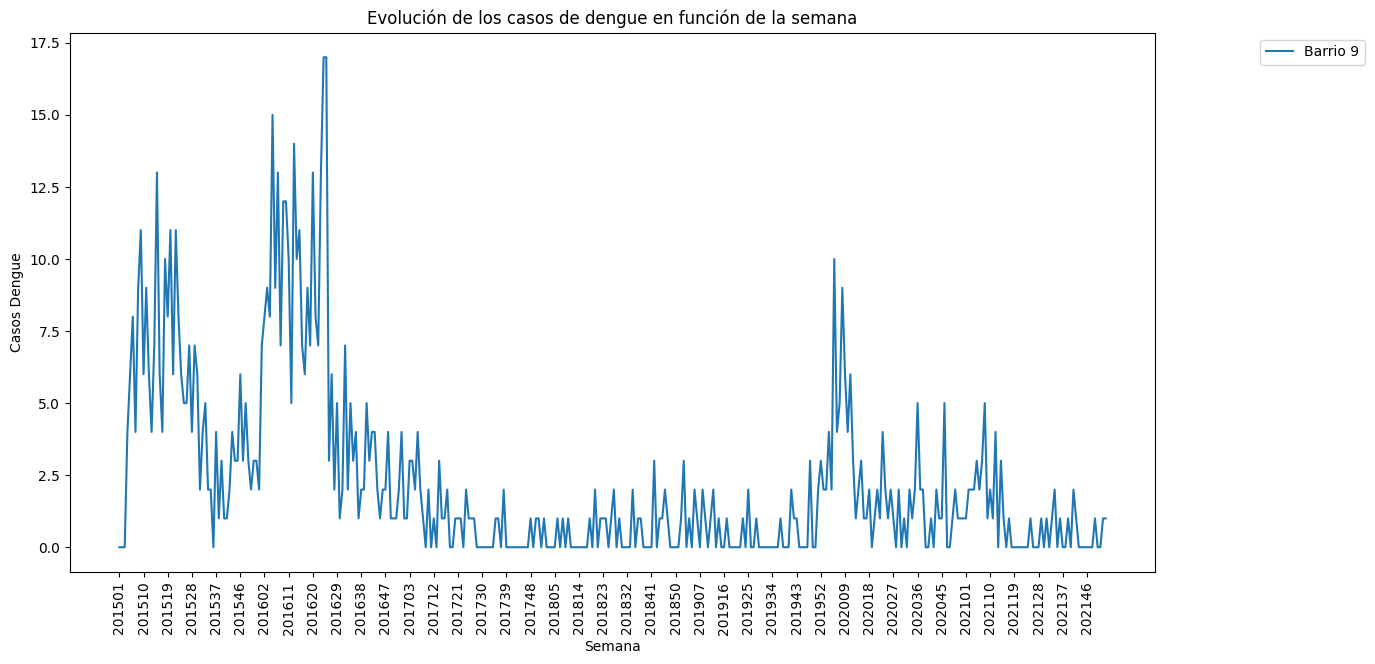

In [12]:
plt.figure(figsize=(14,7))
ax = plt.gca()  # Obtener el eje actual

# Graficar cada barrio en el mismo gráfico
plt.plot(df[df['id_bar'] == barrio_id]['fecha'], df[df['id_bar'] == barrio_id]['dengue'], label=f'Barrio {barrio_id}')

plt.xlabel('Semana')
plt.ylabel('Casos Dengue')
plt.title('Evolución de los casos de dengue en función de la semana')
plt.xticks(np.arange(0,368,9), rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Ajustar la leyenda para que no se sobreponga
plt.show()

## Parámetros

In [13]:
SEQUENCE_LENGTH = 5
TARGET_COLUMN = 'dengue'
GROUP_COLUMN = 'id_bar'

## División temporal train/val

In [14]:
# Ordenar datos
df = df.sort_values(by=[GROUP_COLUMN, 'anio', 'semana'])
features_cols_ini = df.columns.difference(['anio', 'semana', TARGET_COLUMN, GROUP_COLUMN, 'id', 'fecha'])

In [15]:
features_cols_ini

Index(['ESTRATO', 'area_barrio', 'concentraciones', 'equipesado', 'lluvia_max',
       'lluvia_mean', 'lluvia_min', 'lluvia_var', 'maquina', 'sumideros',
       'temperatura_max', 'temperatura_mean', 'temperatura_min',
       'temperatura_var', 'vivienda'],
      dtype='object')

In [16]:
df.anio.value_counts(1).sort_index().cumsum()

anio
2015    0.144022
2016    0.288043
2017    0.429348
2018    0.570652
2019    0.711957
2020    0.855978
2021    1.000000
Name: proportion, dtype: float64

In [17]:
train_df = df[df.anio <= 2020].copy()
val_df = df[df.anio >= 2021].copy()

# Estandarizar

In [18]:
features_cols = features_cols_ini.copy()
scaler = StandardScaler().fit(train_df[features_cols])
train_df[features_cols] = scaler.transform(train_df[features_cols])
val_df[features_cols] = scaler.transform(val_df[features_cols])

In [19]:
train_df

,id,id_bar,anio,semana,ESTRATO,area_barrio,dengue,concentraciones,vivienda,equipesado,sumideros,maquina,lluvia_mean,lluvia_var,lluvia_max,lluvia_min,temperatura_mean,temperatura_var,temperatura_max,temperatura_min,fecha
9,0_2015_01,0,2015,1,0.0,1.956409,0.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.851947,-0.609593,-1.103418,0.0,0.031715,0.102178,-0.909305,0.006634,201501
19,0_2015_02,0,2015,2,0.0,1.956409,3.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.696007,-0.517476,-0.239272,0.0,0.069889,-0.597052,-0.878969,-0.854016,201502
29,0_2015_03,0,2015,3,0.0,1.956409,9.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,1.521162,1.844791,1.941309,0.0,-0.852377,0.051358,-0.514937,-1.132462,201503
39,0_2015_04,0,2015,4,0.0,1.956409,5.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.112871,-0.309490,-0.013394,0.0,-1.619721,-1.212388,-1.698041,-1.132462,201504
49,0_2015_05,0,2015,5,0.0,1.956409,5.0,-0.213619,-0.191787,-0.252060,1.13358,-0.284573,-0.677286,-0.578803,-0.775976,0.0,-0.550665,-1.029579,-1.091321,-0.145245,201505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,9_2020_49,9,2020,49,0.0,-1.433650,1.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.244578,-0.465497,-0.485942,0.0,-0.676754,-1.196244,-1.356761,-0.268648,202049
3114,9_2020_50,9,2020,50,0.0,-1.433650,2.0,-0.213619,-0.191787,-0.252060,-0.01458,-0.284573,-0.337145,-0.354887,-0.132820,0.0,-0.822238,-0.231416,-1.250585,-0.088291,202050
3124,9_2020_51,9,2020,51,0.0,-1.433650,1.0,-0.213619,-0.191787,-0.252060,-0.58866,1.327664,-0.725413,-0.584582,-0.773665,0.0,-0.512646,-0.745166,-1.151993,0.395825,202051
3134,9_2020_52,9,2020,52,0.0,-1.433650,1.0,-0.213619,0.088812,3.155615,-0.01458,-0.284573,0.372659,0.077798,0.334574,0.0,-1.608459,-0.946357,-0.810713,-0.648346,202052


## Estructura de los datos

In [20]:
class DengueDataset(Dataset):
    def __init__(self, df, sequence_length, is_train=True):
        self.sequence_length = sequence_length
        self.is_train = is_train
        self.data = []
        grouped = df.groupby(GROUP_COLUMN)
        for _, group in grouped:
            group = group.reset_index(drop=True)
            if len(group) > sequence_length:
                for i in range(len(group) - sequence_length):
                    seq_x = group.loc[i:i+sequence_length-1, features_cols].values.flatten()
                    if self.is_train:
                        seq_y = group.loc[i+sequence_length, TARGET_COLUMN]
                        self.data.append((seq_x, seq_y))
                    else:
                        seq_id = group.loc[i+sequence_length, 'id']
                        self.data.append((seq_x, seq_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.is_train:
            x, y = self.data[idx]
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        else:
            x, seq_id = self.data[idx]
            return torch.tensor(x, dtype=torch.float32), seq_id

## Ejemplo de la clase DengueDataset

In [21]:
#data = train_df[train_df.id_bar==0].head(10).copy()

In [22]:
#features_cols = ['temperatura_mean', 'lluvia_mean']
#SEQUENCE_LENGTH_p = 3

In [23]:
#data[['semana','id_bar','dengue']+features_cols]

In [24]:
'''# Crear dataset de entrenamiento
dataset_train = DengueDataset(data, SEQUENCE_LENGTH_p, is_train=True)

# Mostrar el tamaño del dataset
print(f"Número de secuencias en el dataset: {len(dataset_train)}")

# Ver algunas muestras del dataset
for i in range(len(dataset_train)):
    print(f"Ejemplo {i+1}:")
    print(f"Entrada (X): {dataset_train[i][0]}")
    print(f"Salida (Y): {dataset_train[i][1]}")
    print("-" * 50)
'''

'# Crear dataset de entrenamiento\ndataset_train = DengueDataset(data, SEQUENCE_LENGTH_p, is_train=True)\n\n# Mostrar el tamaño del dataset\nprint(f"Número de secuencias en el dataset: {len(dataset_train)}")\n\n# Ver algunas muestras del dataset\nfor i in range(len(dataset_train)):\n    print(f"Ejemplo {i+1}:")\n    print(f"Entrada (X): {dataset_train[i][0]}")\n    print(f"Salida (Y): {dataset_train[i][1]}")\n    print("-" * 50)\n'

# Modelo MLP

In [25]:
# Crear loaders
train_loader = DataLoader(DengueDataset(train_df, SEQUENCE_LENGTH), batch_size=32, shuffle=True)
val_loader = DataLoader(DengueDataset(val_df, SEQUENCE_LENGTH), batch_size=32, shuffle=False)

In [26]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimpleMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.fc(x).squeeze()

# Entrenamiento

In [27]:
features_cols = features_cols_ini.copy()
input_size = len(features_cols) * SEQUENCE_LENGTH
model = SimpleMLP(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
for epoch in range(20):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss = criterion(model(x_batch), y_batch)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/20 | Train MSE: {train_loss/len(train_loader):.4f} | Val MSE: {val_loss/len(val_loader):.4f}')

Epoch 1/20 | Train MSE: 15.9699 | Val MSE: 4.2111
Epoch 2/20 | Train MSE: 12.0071 | Val MSE: 5.1151
Epoch 3/20 | Train MSE: 11.3430 | Val MSE: 4.8501
Epoch 4/20 | Train MSE: 10.8489 | Val MSE: 5.0742
Epoch 5/20 | Train MSE: 10.4490 | Val MSE: 5.3067
Epoch 6/20 | Train MSE: 10.0087 | Val MSE: 5.5800
Epoch 7/20 | Train MSE: 9.6675 | Val MSE: 6.1118
Epoch 8/20 | Train MSE: 9.2715 | Val MSE: 5.4915
Epoch 9/20 | Train MSE: 8.9161 | Val MSE: 5.7054
Epoch 10/20 | Train MSE: 8.5321 | Val MSE: 5.3733
Epoch 11/20 | Train MSE: 8.2375 | Val MSE: 5.9212
Epoch 12/20 | Train MSE: 7.9660 | Val MSE: 6.7348
Epoch 13/20 | Train MSE: 7.6582 | Val MSE: 7.3526
Epoch 14/20 | Train MSE: 7.4299 | Val MSE: 6.5804
Epoch 15/20 | Train MSE: 7.2068 | Val MSE: 6.7515
Epoch 16/20 | Train MSE: 6.9936 | Val MSE: 7.2897
Epoch 17/20 | Train MSE: 6.7725 | Val MSE: 7.5499
Epoch 18/20 | Train MSE: 6.5750 | Val MSE: 6.9773
Epoch 19/20 | Train MSE: 6.3627 | Val MSE: 6.9911
Epoch 20/20 | Train MSE: 6.1894 | Val MSE: 7.9617


In [29]:
# Guardar modelo entrenado
torch.save(model.state_dict(), 'dengue_model.pth')

# Submission

In [30]:
# Cargar datos nuevos y preparar submission
features_cols = features_cols_ini.copy()
df_test = pd.read_parquet('/kaggle/input/fa-ii-2025-i-pronosticos-nn-rnn-cnn/df_test.parquet')
df_test = df_test.sort_values(by=[GROUP_COLUMN, 'anio', 'semana'])
df_test[features_cols] = scaler.transform(df_test[features_cols])



In [31]:
# Agregar últimas SEQUENCE_LENGTH filas del entrenamiento a cada grupo de test
historical_sequences = df.groupby(GROUP_COLUMN).tail(SEQUENCE_LENGTH)
df_test_extended = pd.concat([historical_sequences, df_test], ignore_index=True)
df_test_extended = df_test_extended.sort_values(by=[GROUP_COLUMN, 'anio', 'semana']).reset_index(drop=True)

In [32]:
df_test_extended

,id,id_bar,anio,semana,ESTRATO,area_barrio,dengue,concentraciones,vivienda,equipesado,sumideros,maquina,lluvia_mean,lluvia_var,lluvia_max,lluvia_min,temperatura_mean,temperatura_var,temperatura_max,temperatura_min,fecha
0,0_2021_49,0,2021,49,2.0,1.19600,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.403027,1.663283,6.933333,0.0,24.670539,9.759634,32.057143,18.985714,202149
1,0_2021_50,0,2021,50,2.0,1.19600,1.0,45.000000,0.000000,0.00000,3.00000,0.000000,0.070363,0.220006,5.722000,0.0,24.841114,9.028234,30.628571,18.714286,202150
2,0_2021_51,0,2021,51,2.0,1.19600,3.0,27.000000,0.000000,0.00000,0.00000,0.000000,0.191573,1.221716,9.903333,0.0,25.548197,9.265805,31.885714,20.866667,202151
3,0_2021_52,0,2021,52,2.0,1.19600,1.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.142469,0.299902,4.101429,0.0,24.750446,8.778729,31.028571,20.787500,202152
4,0_2021_53,0,2021,53,2.0,1.19600,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.277575,2.310524,10.090138,0.0,25.824778,11.174080,32.994039,20.705364,202153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,9_2022_48,9,2022,48,0.0,-1.43365,NaN,0.191376,-0.191787,-0.25206,-0.58866,-0.284573,-0.274485,-0.437729,-0.257044,0.0,-2.399257,-1.858866,-2.142969,-0.661636,NaN
566,9_2022_49,9,2022,49,0.0,-1.43365,NaN,0.191376,-0.191787,-0.25206,-0.58866,-0.284573,-0.521876,-0.537992,-0.474568,0.0,-1.405599,0.669642,-0.909305,-1.269154,NaN
567,9_2022_50,9,2022,50,0.0,-1.43365,NaN,4.038828,-0.191787,-0.25206,-0.01458,-0.284573,-0.803032,-0.606346,-0.955469,0.0,-0.669715,0.858326,-0.626169,-0.373065,NaN
568,9_2022_51,9,2022,51,0.0,-1.43365,NaN,-0.213619,-0.191787,-0.25206,-0.58866,-0.284573,-0.103165,-0.057858,0.418457,0.0,-0.494291,1.545264,0.203016,-0.562914,NaN


In [33]:
# Crear loader para predicción
test_loader = DataLoader(DengueDataset(df_test_extended, SEQUENCE_LENGTH, is_train=False), batch_size=32, shuffle=False)

In [34]:
# Crear loader para predicción
test_loader = DataLoader(DengueTestDataset(df_test_extended, SEQUENCE_LENGTH), batch_size=64, shuffle=False)

NameError: name 'DengueTestDataset' is not defined

In [ ]:
# Generar predicciones
model.eval()
predictions = []
ids = []

with torch.no_grad():
    for x_batch, id_batch in test_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).cpu().numpy()
        predictions.extend(preds)
        ids.extend(id_batch)


In [ ]:
len(ids)

In [ ]:
# Preparar submission con todos los registros
df_submission = pd.DataFrame({'id': ids, 'dengue': predictions})

# Exportar a CSV
df_submission.to_csv('submission.csv', index=False)
print(f'Submission guardado en submission.csv, con {len(df_submission)} predicciones.')

In [ ]:
df_submission